# PyTorch

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

## Dataset

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-04-12 23:05:43--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.139.90, 52.222.139.21, 52.222.139.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.139.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  43.4MB/s    in 1.0s    

2023-04-12 23:05:44 (43.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualizando Dados

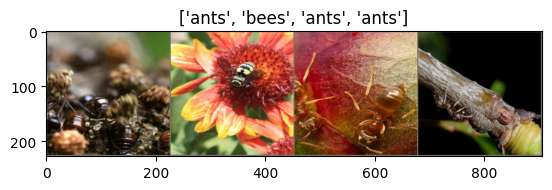

In [ ]:
# imshow para imagens em tensores
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Modelo: Convnet

<img src="https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png" />

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.7MB/s]


### Treinamento

In [ ]:
def treinamento(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
          scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Perda: {epoch_loss:.4f} Acur: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Treinamento completo em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Melhor acurácia: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

model_ft = treinamento(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Perda: 0.5825 Acur: 0.7172
val Perda: 0.2235 Acur: 0.9281

Epoch 1/24
----------
train Perda: 0.5985 Acur: 0.7910
val Perda: 0.3570 Acur: 0.9150

Epoch 2/24
----------
train Perda: 0.6377 Acur: 0.8074
val Perda: 0.4115 Acur: 0.8170

Epoch 3/24
----------
train Perda: 0.5026 Acur: 0.7705
val Perda: 0.3853 Acur: 0.8627

Epoch 4/24
----------
train Perda: 0.5002 Acur: 0.8156
val Perda: 0.3062 Acur: 0.8889

Epoch 5/24
----------
train Perda: 0.5308 Acur: 0.8238
val Perda: 0.3103 Acur: 0.9020

Epoch 6/24
----------
train Perda: 0.4795 Acur: 0.7705
val Perda: 0.3196 Acur: 0.9020

Epoch 7/24
----------
train Perda: 0.3148 Acur: 0.8648
val Perda: 0.3347 Acur: 0.9020

Epoch 8/24
----------
train Perda: 0.2896 Acur: 0.8689
val Perda: 0.3202 Acur: 0.9020

Epoch 9/24
----------
train Perda: 0.2122 Acur: 0.9098
val Perda: 0.3229 Acur: 0.9150

Epoch 10/24
----------
train Perda: 0.3160 Acur: 0.8893
val Perda: 0.2759 Acur: 0.9216

Epoch 11/24
----------
train Perda: 0.3312

### Avaliando Treinamento

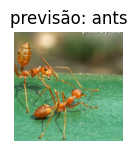

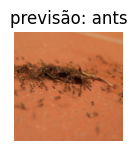

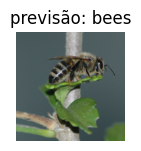

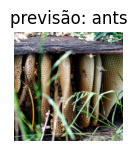

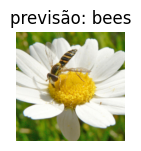

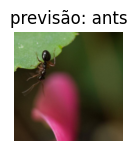

In [ ]:
def visualizando(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'previsão: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
            model.train(mode=was_training)
            return
  model.train(mode=was_training)

visualizando(model_ft)

# Keras TensorFlow

Ambiente de Execução >> Desconectar e excluir ambiente de execução

Motivo: problemas nas bibliotecas com mesmo nome no Torch e TensorFlow.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Dataset: Gatos e Cães

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   167M      0  0:00:04  0:00:04 --:--:--  167M


Removendo imagens com problemas:

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()
    if not is_jfif:
      num_skipped += 1
      # Delete corrupted image
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Visualizando Dados

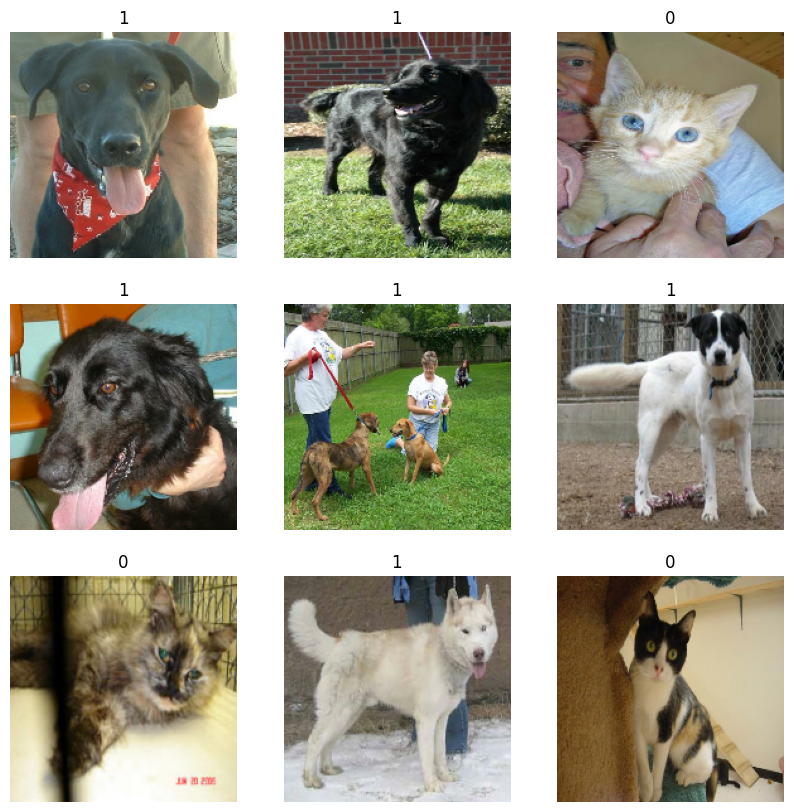

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

### Aumento de Dados

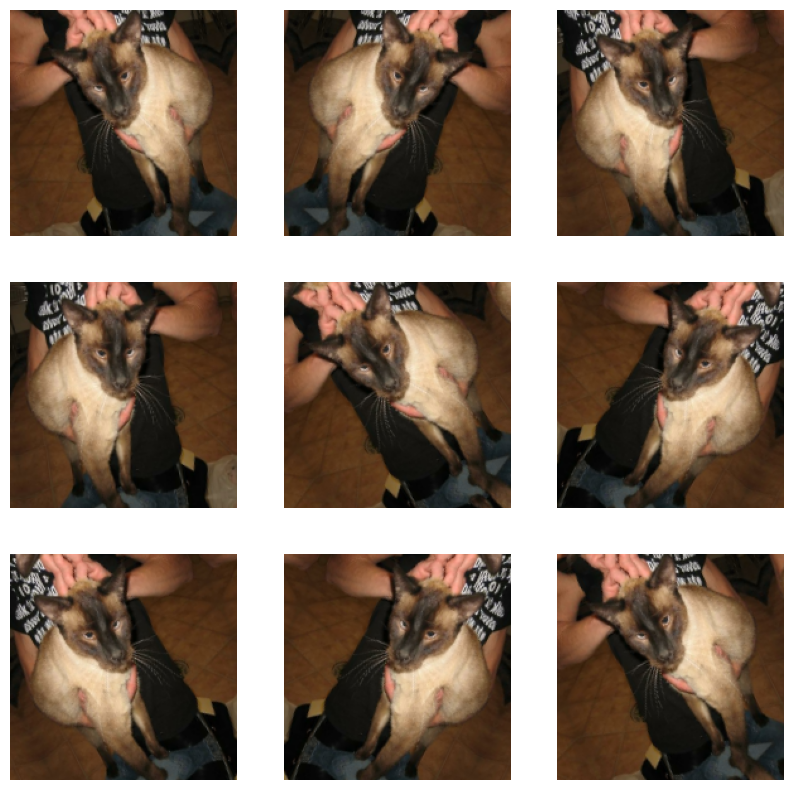

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
  ])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Otimizando Dataset

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Modelo da Rede Neural Profunda

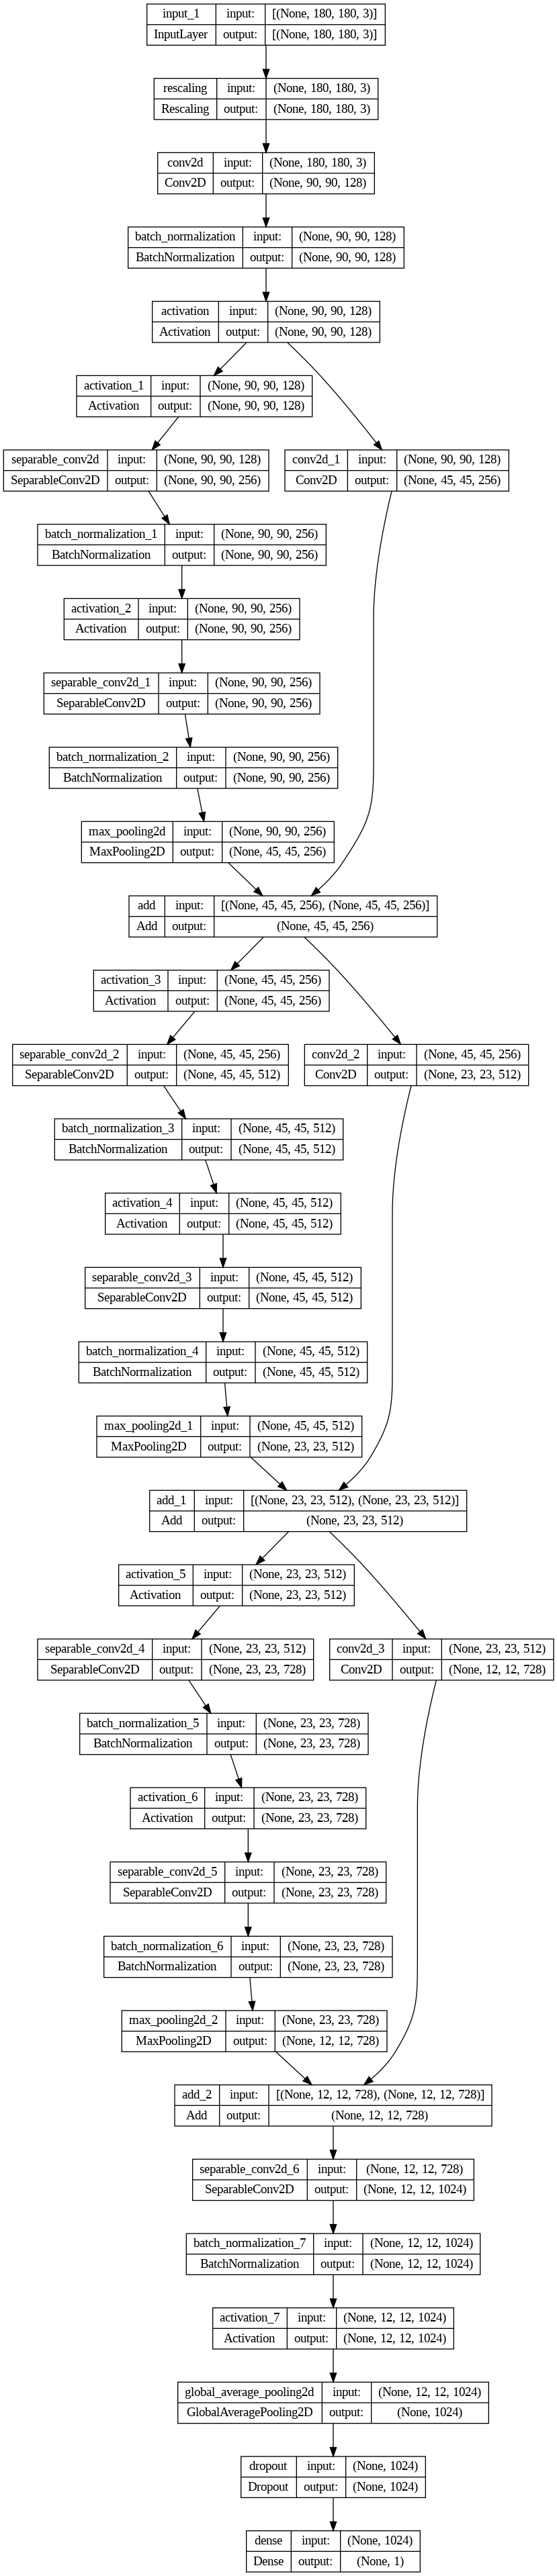

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

### Treinamento

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])

model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
 77/147 [==============>...............] - ETA: 1:34 - loss: 0.6870 - accuracy: 0.6121

KeyboardInterrupt: ignored

### Avaliando Treinamento

In [ ]:
img = keras.preprocessing.image.load_img( "PetImages/Cat/6779.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")